In [1]:
import cell2cell as c2c
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import skbio

%matplotlib inline

# Analysis Setup

Here, all inputs and parameters needed for the analysis are defined

**Location of files**

In [2]:
C2C_ROOT = '../'

In [3]:
files = dict()
files['rnaseq'] = C2C_ROOT + '/data/CElegans_RNASeqData_Cell.xlsx'
files['ppi'] = C2C_ROOT + '/data/CElegans_PPIs_STRING.txt.gz'
files['go_annotations'] = C2C_ROOT + '/data/wb.gaf.gz'
files['go_terms'] = C2C_ROOT + '/data/go-basic.obo'
files['output_folder'] = C2C_ROOT + '/outputs/'

**RNA-seq data manipulation**

- <font color="green">'gene_col'</font> is the name of the column containing the list or names of genes in the dataset.
- <font color="green">'drop_nangenes'</font> is a boolean decision to remove those genes with NaN values.
- <font color="green">'log_transform'</font> is a boolean decision to log-transform the dataset.

In [4]:
rnaseq_setup = dict()
rnaseq_setup['gene_col'] = 'gene_id'
rnaseq_setup['drop_nangenes'] = True
rnaseq_setup['log_transform'] = False

**Columns for PPI network**

- <font color="green">'protein_cols'</font> is a list containing the names of the first and second interactors.

In [5]:
ppi_setup = dict()
ppi_setup['protein_cols'] = ['protein1', 'protein2']

**Cutoffs setup for binarizing gene expression**

- <font color="green">'type'</font> is the type of cutoff to use. So far, only 'local_percentile' and 'global_percentile' are implemented.
- <font color="green">'parameter'</font> is the corresponding parameter for the type of cutoff. If percentile is used, it should be a value between 0 and 1. E.g. a value of 0.8 represents the 80-th percentile.

In [6]:
cutoff_setup = dict()
cutoff_setup['type'] = 'local_percentile'
cutoff_setup['parameter'] = 0.75

**GO annotation and terms to filter PPI network**

- <font color="green">'experimental_evidence'</font> is a boolean decision to consider only GO annotations of genes that have experimental support (e.g. associated articles).
- <font color="green">'descendants'</font> is a boolean decision to consider the GO terms that are children of a given GO term (based on their hierarchy).

In [7]:
go_setup = dict()
go_setup['experimental_evidence'] = True
go_setup['descendants'] = True

**General Analysis setups**

- <font color="green">'interaction_type'</font> is the type of intercellular interaction to analyze. It could be 'contacts', 'mediated', or 'combined'. The last one considers 'contacts' and 'mediated' together.
- <font color="green">'score_type'</font> is the type of score to calculate the interaction index for a pair of cells. It could be 'binary' to use 0 or 1 values of gene expression depending on a cutoff value for each one or 'weighted' to use a continue value between 0 and 1 given the maximal expression level of each gene. WARNING: 'weighted' is an experimental method.
- <font color="green">'subsampling_space'</font> is the ratio of cells to be randomly considered in each iteration to compute the interactions. Here, iterations are used especially when using percentile cutoff, to avoid enrichment for cell types with high expression levels of certain genes.
- <font color="green">'iterations'</font> is the number of iterations to perform different random subsamplings.
- <font color="green">'cpu_cores'</font> is the number of cores to use and run parallelly the iterations for subsampling.

In [8]:
analysis_setup = dict()
analysis_setup['interaction_type'] = ['contacts', 'mediated', 'combined']
analysis_setup['score_type'] = 'binary'
analysis_setup['subsampling_percentage'] = 0.75
analysis_setup['iterations'] = 1000
analysis_setup['cpu_cores'] = 7 # To enable parallel computing

# Load Data

**RNA-seq**

In [9]:
rnaseq_data = c2c.io.load_rnaseq(rnaseq_file=files['rnaseq'],
                                 gene_column=rnaseq_setup['gene_col'],
                                 drop_nangenes=rnaseq_setup['drop_nangenes'],
                                 log_transformation=rnaseq_setup['log_transform'],
                                 format='auto')

Opening RNAseq datasets from ..//data/CElegans_RNASeqData_Cell.xlsx
..//data/CElegans_RNASeqData_Cell.xlsx was correctly loaded


**PPI network**

In [10]:
ppi_data = c2c.io.load_ppi(ppi_file=files['ppi'],
                           interaction_columns=ppi_setup['protein_cols'],
                           rnaseq_genes=list(rnaseq_data.index),
                           format='auto')

Opening PPI datasets from ..//data/CElegans_PPIs_STRING.txt.gz
..//data/CElegans_PPIs_STRING.txt.gz was correctly loaded
Removing bidirectionality of PPI network
Simplying PPI network


**GO annotations and GO terms**

In [11]:
go_annotations = c2c.io.load_go_annotations(goa_file=files['go_annotations'],
                                            experimental_evidence=go_setup['experimental_evidence'])

go_terms = c2c.io.load_go_terms(go_terms_file=files['go_terms'])

Opening GO annotations from ..//data/wb.gaf.gz


/Users/earmingol/anaconda3/envs/c2c_dev/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: DtypeWarning: Columns (9,15) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


..//data/wb.gaf.gz was correctly loaded
Opening GO terms from ..//data/go-basic.obo
..//data/go-basic.obo was correctly loaded


**Metadata for cell types**

In [12]:
meta = c2c.io.load_table(C2C_ROOT + '/data/CElegans_cell_metadata.tsv', format='auto')
meta.index = [str(i) for i, c in enumerate(rnaseq_data.columns)]

..//data/CElegans_cell_metadata.tsv was correctly loaded


# Run Analysis

**Obtain PPI networks for all types of interactions (contact, mediated and combined interactions)**

This generates a dictionary containing PPI networks for each interaction type. The PPI networks are filtered with the respective GO terms.

The default GO terms used for the heuristic approach are contained in an instance of c2c.datasets.HeuristicGO. For contact proteins (those on cell surface) use <font color="blue">*c2c.datasets.HeuristicGO.contact_go_terms*</font> and for secreted or extracellular proteins use <font color="blue">*c2c.datasets.HeuristicGO.mediator_go_terms*</font>. Specific GO terms that include certain keyword using the function <font color="blue">*c2c.preprocessing.find_go_terms_from_keyword(go_term, 'keyword')*</font>.

Additionally, instead of finding genes heuristically from GO terms, we can provide a manually curated list of genes/proteins in *contact_proteins* and *mediator_proteins*. Then, those loaded lists could be directly passed to <font color="blue">*c2c.preprocessing.get_ppi_dict_from_proteins(ppi_data, contact_proteins, mediator_proteins)*</font>.

**Generate list of genes associated to cell contacts**

In [13]:
default_go_terms = c2c.datasets.HeuristicGO()

In [14]:
contact_genes = c2c.preprocessing.get_genes_from_go_hierarchy(go_annotations,
                                                              go_terms,
                                                              default_go_terms.contact_go_terms)

Filtering genes by using GO terms


**Generate list of genes associated to secreted and mediator proteins of cells**

In [15]:
mediator_genes = c2c.preprocessing.get_genes_from_go_hierarchy(go_annotations,
                                                               go_terms,
                                                               default_go_terms.mediator_go_terms)

Filtering genes by using GO terms


**Generate PPIs for all interaction types**

In [16]:
ppi_dict = c2c.preprocessing.get_ppi_dict_from_proteins(ppi_data,
                                                        contact_genes,
                                                        mediator_genes)

Filtering PPI interactions by using a list of genes for contacts interactions
Making bidirectional PPI for CCI.
Removing duplicates in bidirectional PPI network.
Filtering PPI interactions by using a list of genes for mediated interactions
Making bidirectional PPI for CCI.
Removing duplicates in bidirectional PPI network.
Filtering PPI interactions by using a list of genes for combined interactions
Making bidirectional PPI for CCI.
Removing duplicates in bidirectional PPI network.


In [17]:
for interaction, ppi in ppi_dict.items():
    print('{} has {} PPIs'.format(interaction, len(ppi)))

contacts has 3480 PPIs
mediated has 2408 PPIs
combined has 5638 PPIs


**Compute CCI values for each random subsampling round**

In [18]:
subsampling_space = dict()
distance_cci = dict()
for interaction in analysis_setup['interaction_type']:
    print('Running analysis for ' + interaction)
    subsampling_space[interaction] = c2c.core.SubsamplingSpace(rnaseq_data=rnaseq_data,
                                                               ppi_dict=ppi_dict,
                                                               interaction_type=interaction,
                                                               gene_cutoffs=cutoff_setup,
                                                               score_type=analysis_setup['score_type'],
                                                               subsampling_percentage=analysis_setup['subsampling_percentage'],
                                                               iterations=analysis_setup['iterations'],
                                                               n_jobs=analysis_setup['cpu_cores'],
                                                               initial_seed=0, # Random seed to compare results and conditions
                                                               verbose=False)
    
    # Since the CCI matrix can be considered as a similarity matrix, 
    # we can compute pseudo-distances between cells, then cluster them.
    distance_cci[interaction] = subsampling_space[interaction].average_cci_matrix.apply(lambda x: 1-x)
    
    #Remove self distances
    np.fill_diagonal(distance_cci[interaction].values, 0.0)

Running analysis for contacts
Running analysis for mediated
Running analysis for combined


# Clustering

**Hierarchical Clustering on Average CCI matrices**

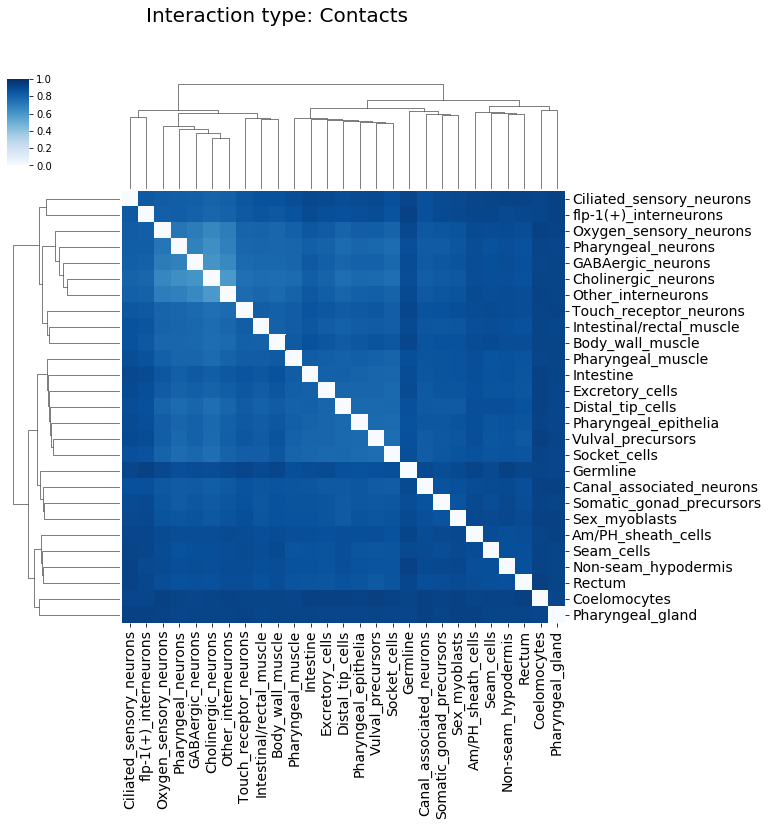

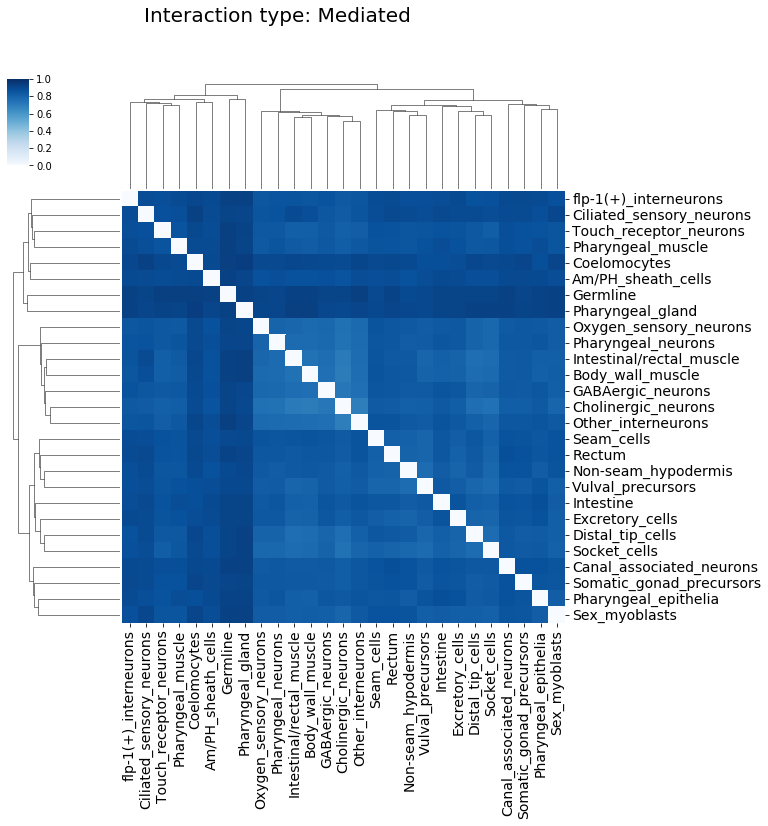

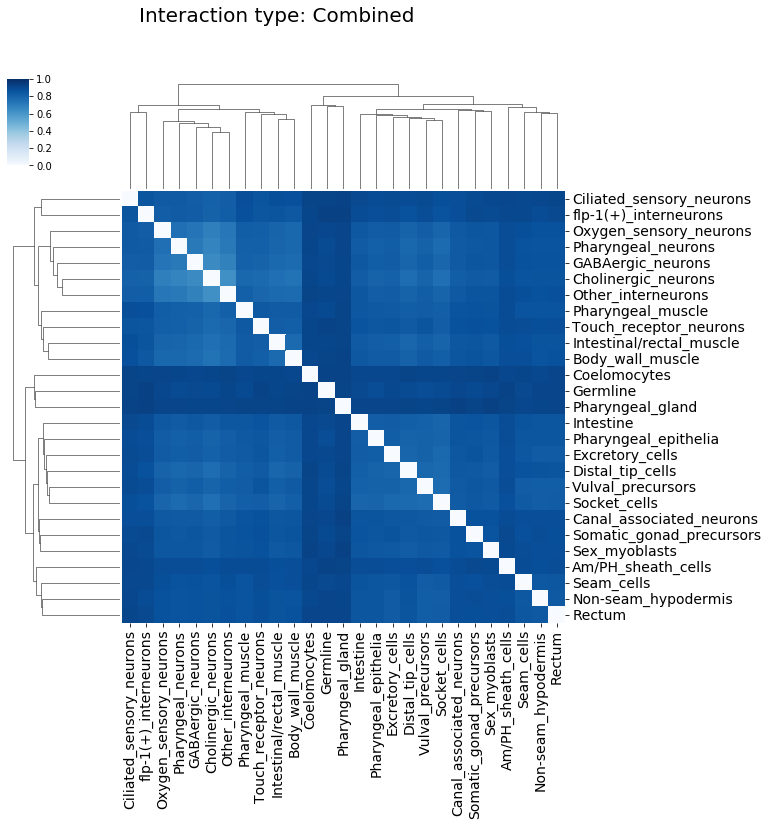

In [34]:
linkages=dict()
for interaction, distance_matrix in distance_cci.items():
    # Compute linkage
    linkages[interaction] = c2c.clustering.compute_linkage(distance_matrix, method='ward')
    
    # Plot hierarchical clustering
    hier = sns.clustermap(distance_matrix,
                          col_linkage=linkages[interaction],
                          row_linkage=linkages[interaction],
                          cmap='Blues',
                          vmin=0,
                          vmax=1,
                          figsize=(10,10),
                          )
    
    hier.fig.suptitle('Interaction type: ' + interaction.capitalize(), fontsize=20) 
    
    tick_size = 14
    hier.ax_heatmap.set_xticklabels(hier.ax_heatmap.get_xmajorticklabels(), fontsize = tick_size)
    hier.ax_heatmap.set_yticklabels(hier.ax_heatmap.get_ymajorticklabels(), fontsize = tick_size)
    
    plt.savefig(files['output_folder'] + '/Clustermap-{}.png'.format(interaction.capitalize()),
                dpi = 300,
                bbox_inches='tight')

# PCoA

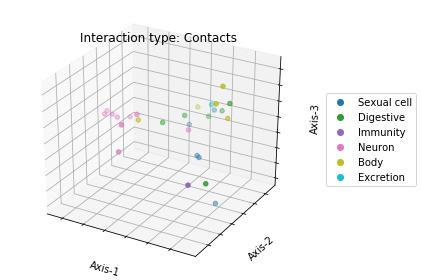

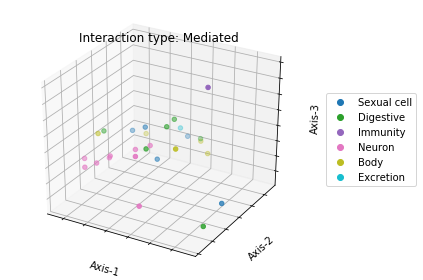

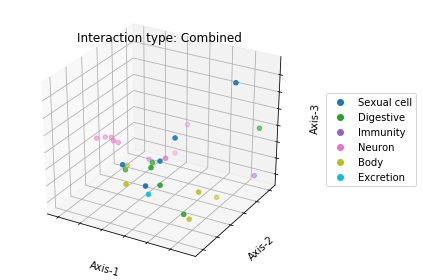

In [20]:
for interaction, distance_matrix in distance_cci.items():
    # PCoA
    ordination = skbio.stats.ordination.pcoa(distance_matrix)
    biplot = ordination.plot(df=meta, column='type', cmap='tab10',
                             axis_labels=('Axis-1','Axis-2','Axis-3'))
    plt.title('Interaction type: ' + interaction.capitalize()) 
    
    # Export data for using in Qiime2
    distskbio = skbio.DistanceMatrix(distance_matrix, ids=distance_matrix.index)
    distskbio.write(files['output_folder'] + '/{}-STRING_Distance_{}.txt'.format(analysis_setup['score_type'],
                                                                                 interaction.capitalize()))
    ordination.samples.index = distance_matrix.index
    ordination.write(files['output_folder'] + '/{}-STRING_Ordination_{}.txt'.format(analysis_setup['score_type'],
                                                                                    interaction.capitalize()))

meta.to_csv(files['output_folder'] + "/metadata.tsv", sep="\t", index=False)

# Detecting Important PPIs

In [21]:
clusters=dict()
for interaction in linkages.keys():
    clusters[interaction] = c2c.clustering.get_clusters_from_linkage(distance_cci[interaction],
                                                                     linkages[interaction],
                                                                     6)
    

In [22]:
ppi_stats = dict()

for interaction, cluster in clusters.items():
    print('Getting important PPIs for {}'.format(interaction))
    ppi_stats[interaction] = dict()
    ppi_stats[interaction]['mean'], ppi_stats[interaction]['std'] = c2c.analysis.compute_avg_count_for_ppis(subsampling_space[interaction].subsampled_interactions,
                                                                                                            cluster,
                                                                                                            ppi_dict)

    

Getting important PPIs for contacts
Getting important PPIs for mediated
Getting important PPIs for combined


In [23]:
c2c.io.export_variable_with_pickle(ppi_stats, files['output_folder'] + '/binary-STRING-ppi_stats.pkl')
c2c.io.export_variable_with_pickle(clusters, files['output_folder'] + '/binary-STRING-clusters.pkl')